# Training

Plots del entrenamiento, leemos el json del log generado por Transformers.

train_1train_2_train_3_
train_1train_2_train_3_
train_1train_2_train_3_


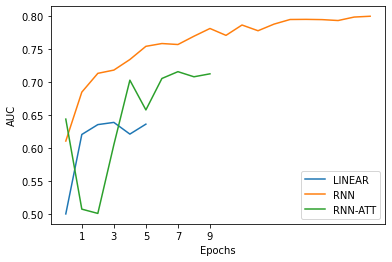

train_4train_5_train_6_
train_4train_5_train_6_
train_4train_5_train_6_


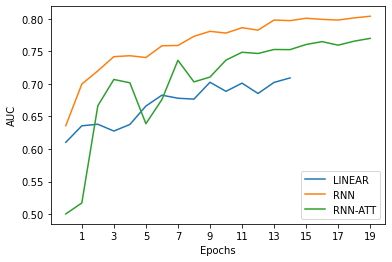

train_7train_8_train_9_
train_7train_8_train_9_
train_7train_8_train_9_


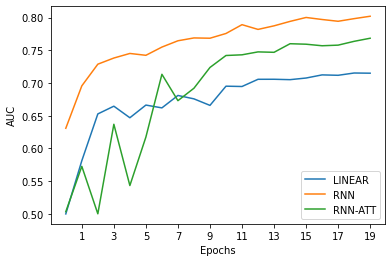

In [30]:

import os
import json
import matplotlib.pyplot as plt
from functools import reduce

def read_checkpoint(folder):
    file_json = open(folder + "/" + "trainer_state.json", "r")
    data_json = json.loads(file_json.read())

    lr_List = []
    acc_List = []
    auc_List = []
    presicion_List = []
    recall_List = []
    fscore_List = []

    for i in range(1, len(data_json["log_history"]), 2):
        lr_List.append(data_json["log_history"][i-1]["learning_rate"])
        acc_List.append(data_json["log_history"][i]["eval_accuracy"])
        auc_List.append(data_json["log_history"][i]["eval_auc"])
        presicion_List.append(data_json["log_history"][i]["eval_precision"])
        recall_List.append(data_json["log_history"][i]["eval_recall"])
        fscore_List.append(data_json["log_history"][i]["eval_f1"])

    return lr_List, acc_List, auc_List, presicion_List, recall_List, fscore_List


def plots(folders):
    for i, folder in enumerate(folders):
        path = "results/" + folder
        checkpoints = os.listdir(path)    
        
        # buscamos el ultimo checkpoint
        checkpoints_id_list = []
        for cp in checkpoints:
            if cp[:10] == "checkpoint":
                checkpoints_id_list.append(int(cp[11:len(cp)]))         
        max_id = max(checkpoints_id_list)

        # leemos las métricas
        lr, acc, auc, presicion, recall, f1 = read_checkpoint(path + "/checkpoint-" + str(max_id))

        # graficamos
        #plt.plot(range(len(auc)),auc, label=folder[:len(folder) -1]) 
        plt.plot(range(len(auc)),auc, label=model_names[i]) 

        plt.xticks(range(1,len(auc), 2))
        plt.legend(loc ="lower right")
        plt.xlabel("Epochs")
        plt.ylabel("AUC")

        tmp = list(map(lambda x: x[:len(x) - 1], folders) )
        name = reduce(lambda a,b: a+b + '_', tmp) 
        print(name)
        plt.savefig('training_' + name , dpi=300)

    plt.show()

#folders = ["train_1/", "train_2/", "train_3/", "train_4/", "train_5/", 
#           "train_6/", "train_7/", "train_8/", "train_9/"]

model_names = ["LINEAR", "RNN", "RNN-ATT"]

plots(["train_1/", "train_2/", "train_3/"] )
plots(["train_4/", "train_5/", "train_6/"] )
plots(["train_7/", "train_8/", "train_9/"] )

# Predictions

In [43]:
# load model
from model_utils import BertForSequenceClassification, ProteinBertSequenceClsRnnAtt, ProteinBertSequenceClsRnn
from transformers import BertConfig
from transformers import Trainer, TrainingArguments, BertConfig
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef, roc_auc_score

def compute_metrics(pred):
    labels = pred.label_ids
    prediction=pred.predictions
    preds = prediction.argmax(-1)
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    precision = tp / (tp + fp) 
    recall = tp / (tp + fn)
    sn = tp / (tp + fp)       
    sp = tn / (tn + fp)  # true negative rate
    mcc = matthews_corrcoef(labels, preds)
    acc = accuracy_score(labels, preds)
    auc = roc_auc_score(labels, preds)
    f1 = 2 * (precision * recall) / (precision + recall)
    return {
        'auc': auc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'sn': sn,
        'sp': sp,
        'accuracy': acc,
        'mcc': mcc
    }



PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [49]:
model_name = "models/train_2"
tokenizer_name = "../models/esm2_t6_8M_UR50D"
num_labels = 2
config = BertConfig.from_pretrained(model_name, num_labels=num_labels )
config.rnn = "lstm"
config.num_rnn_layer = 2
config.rnn_dropout = 0.1
config.rnn_hidden = 768
config.length = 51
config.cnn_filters = 512
config.cnn_dropout = 0.1

model = Trainer(   
        #model           = BertForSequenceClassification.from_pretrained(model_name, num_labels=2),  # Funciona bien
        model           = ProteinBertSequenceClsRnn.from_pretrained(model_name, config=config),
        #model           = ProteinBertSequenceClsRnnAtt.from_pretrained(model_name, config=config),    # ProBERT+BiLSTM+Attention
        compute_metrics = compute_metrics,  # evaluation metrics        
    )

loading configuration file models/train_2/config.json
Model config BertConfig {
  "_name_or_path": "../models/esm2_t6_8M_UR50D",
  "architectures": [
    "ProteinBertSequenceClsRnn"
  ],
  "attention_probs_dropout_prob": 0.0,
  "classifier_dropout": null,
  "cnn_dropout": 0.1,
  "cnn_filters": 512,
  "emb_layer_norm_before": false,
  "esmfold_config": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 320,
  "initializer_range": 0.02,
  "intermediate_size": 1280,
  "is_folding_model": false,
  "layer_norm_eps": 1e-05,
  "length": 51,
  "mask_token_id": 32,
  "max_position_embeddings": 1026,
  "model_type": "bert",
  "num_attention_heads": 20,
  "num_hidden_layers": 6,
  "num_rnn_layer": 2,
  "pad_token_id": 1,
  "position_embedding_type": "rotary",
  "rnn": "lstm",
  "rnn_dropout": 0.1,
  "rnn_hidden": 768,
  "token_dropout": true,
  "torch_dtype": "float32",
  "transformers_version": "4.24.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_list": null,

In [50]:
from data_loader import My_Load_Dataset

test_dataset = My_Load_Dataset(path="../dataset/netMHCIIpan3.2/test_mini.csv", tokenizer_name=tokenizer_name, max_length=71)
predictions, label_ids, metrics = model.predict(test_dataset)
print(metrics)

loading file vocab.txt
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json
***** Running Prediction *****
  Num examples = 13429
  Batch size = 8
100%|██████████| 1679/1679 [00:22<00:00, 73.55it/s]

{'test_loss': 0.4121377766132355, 'test_auc': 0.8029049642214975, 'test_precision': 0.782048889718231, 'test_recall': 0.7541839121828324, 'test_f1': 0.7678636863319898, 'test_sn': 0.782048889718231, 'test_sp': 0.8516260162601627, 'test_accuracy': 0.8113038945565567, 'test_mcc': 0.609284993618829, 'test_runtime': 22.8443, 'test_samples_per_second': 587.849, 'test_steps_per_second': 73.498}
